# Predict stock price using Time Series analysis with Seasonal ARIMA model

Importing and installing libraries

In [9]:
!pip install -U statsmodels

In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
plt.style.use(style="seaborn")

In [11]:
##Importing Packages
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy import stats 
from statsmodels.graphics.gofplots import qqplot as qq
from scipy.stats import kurtosis
import scipy
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.core.window.rolling import Rolling
from sklearn.model_selection import train_test_split as split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import warnings
import itertools
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
from IPython import display
from matplotlib import pyplot
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import warnings
from matplotlib.patches import Patch

## Loading Data

From Yahoo Finance using yfinance package

In [12]:
!pip install yfinance
import yfinance as yf

In [13]:
data = yf.download("AAPL", start="2012-01-01", end="2019-12-31")

[*********************100%***********************]  1 of 1 completed


In [14]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-16,69.250000,70.197502,69.245003,69.964996,68.543137,128186000
2019-12-17,69.892502,70.442497,69.699997,70.102501,68.677849,114158400
2019-12-18,69.949997,70.474998,69.779999,69.934998,68.513756,116028400
2019-12-19,69.875000,70.294998,69.737503,70.004997,68.582314,98369200
2019-12-20,70.557503,70.662498,69.639999,69.860001,68.440269,275978000
2019-12-23,70.132500,71.062500,70.092499,71.000000,69.557106,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.623222,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.004593,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.977638,146266000


In [15]:
##Data Summary
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,31.676867,31.956899,31.395064,31.685309,29.471148,2.379867e+08
std,12.620938,12.731575,12.531235,12.644592,12.931796,1.873543e+08
min,13.856071,14.271429,13.753571,13.947500,12.064585,4.544800e+07
25%,21.470714,21.679464,21.264108,21.550535,18.509645,1.103426e+08
50%,28.262501,28.547501,27.967501,28.262501,25.948919,1.738760e+08
75%,41.297501,41.852499,40.856249,41.311251,39.469063,2.988412e+08
max,72.779999,73.492500,72.029999,72.879997,71.398888,1.506120e+09


In [16]:
##Exploring Data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB


## Data Preprocessing

Converting Date to DateTime Object

In [17]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.set_index('Date', inplace=True)

In [18]:
##Checking Null Values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Visualizing

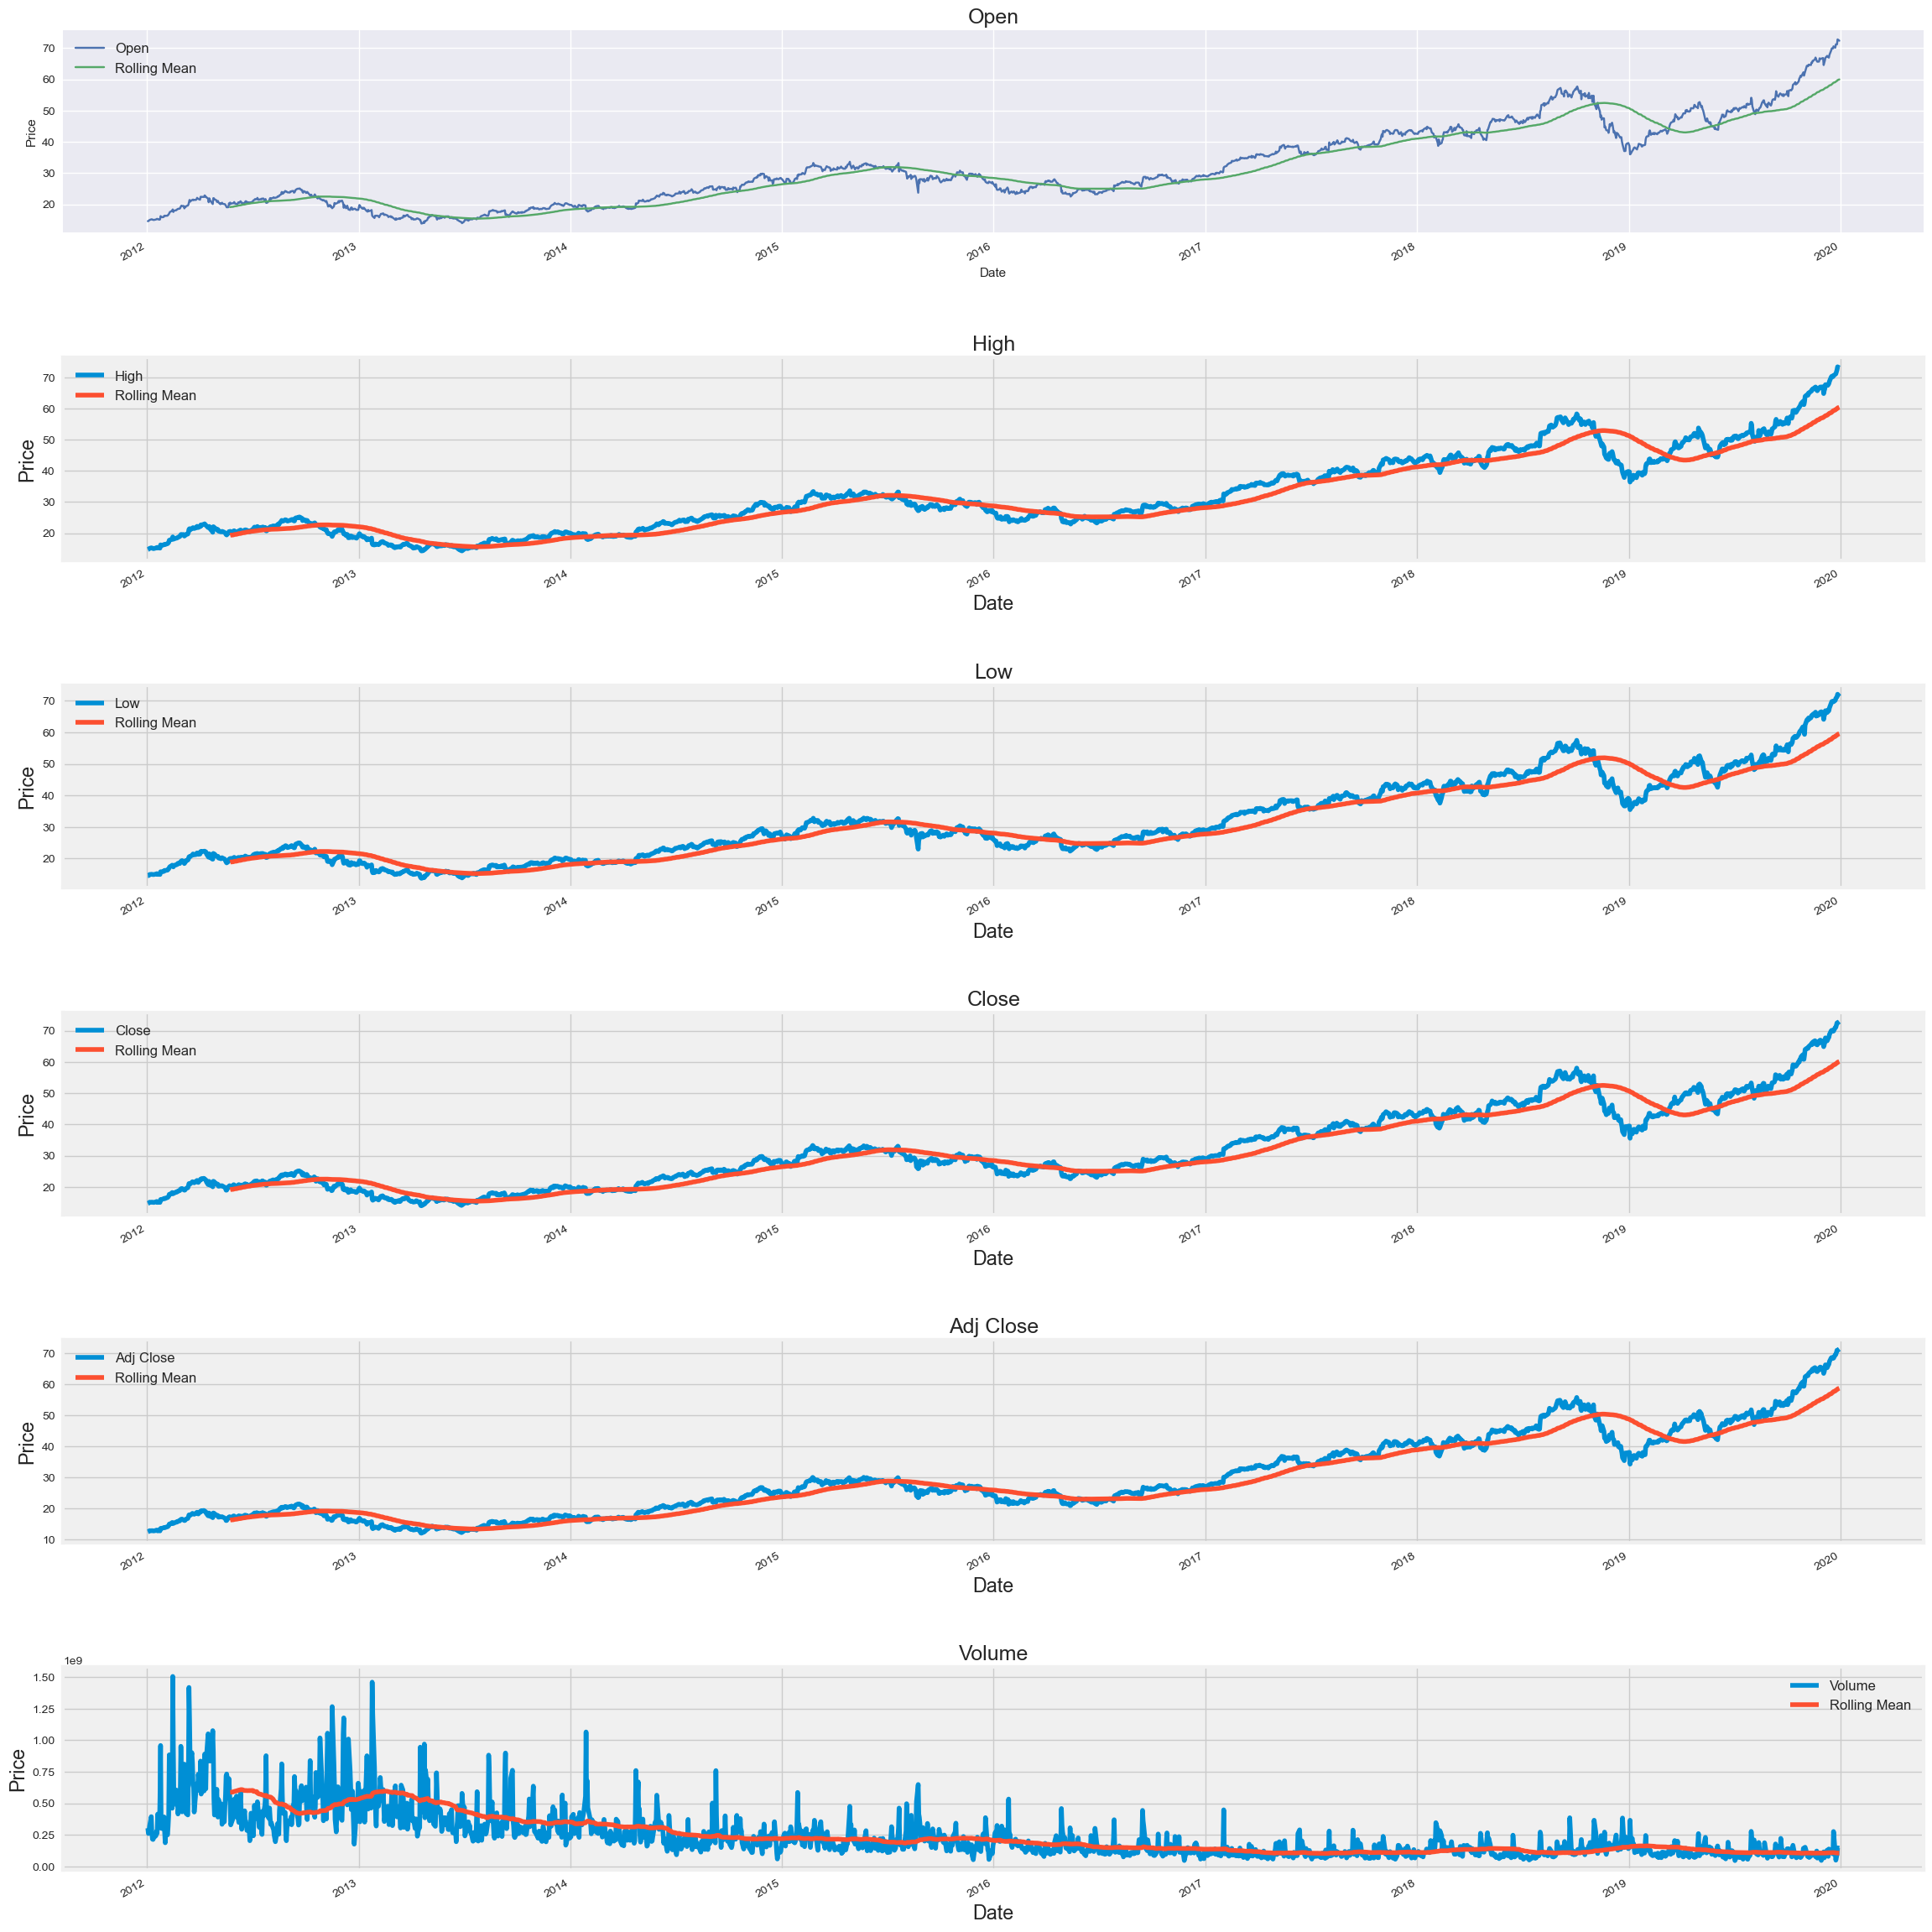

In [19]:
col_names = data.columns

fig = plt.figure(figsize=(24, 24))
for i in range(6):
  ax = fig.add_subplot(6,1,i+1)
  ax.plot(data.iloc[:,i],label=col_names[i])
  data.iloc[:,i].rolling(100).mean().plot(label='Rolling Mean')
  ax.set_title(col_names[i],fontsize=18)
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  ax.patch.set_edgecolor('black')  
  plt.style.context('fivethirtyeight')
  plt.legend(prop={'size': 12})
  plt.style.use('fivethirtyeight')

fig.tight_layout(pad=3.0)

plt.show()

## Choosing target variable

In this analysis we will use Adj Close as our target variables we can eliminate features like Open,Low, High Close automatically.

In [20]:
data_feature_selected = data.drop(axis=1,labels=['Open','High','Low','Adj Close','Volume'])

In [21]:
col_order = ['Close']
data_feature_selected = data_feature_selected.reindex(columns=col_order)
data_feature_selected

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2019-12-23,71.000000
2019-12-24,71.067497
2019-12-26,72.477501


## Resampling

In [22]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
monthly_mean = data_feature_selected['Close'].resample('M').mean()

In [23]:
monthly_data = monthly_mean.to_frame()
monthly_data

,Close
Date,
2012-01-31,15.306357
2012-02-29,17.770393
2012-03-31,20.625276
2012-04-30,21.642964
2012-05-31,20.166899
...,...
2019-08-31,51.239432
2019-09-30,54.498750
2019-10-31,58.821630


## Exploratory Data Analysis

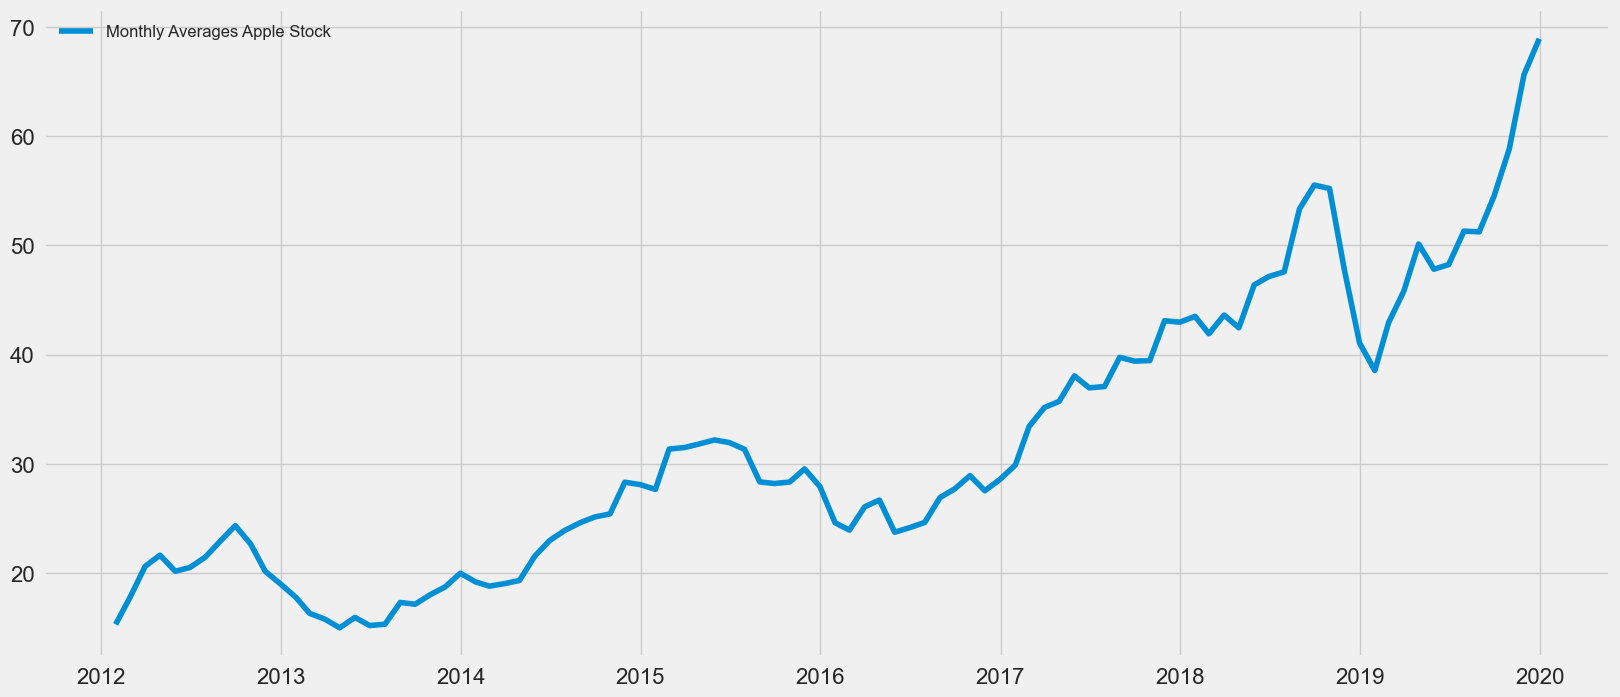

In [24]:
##Monthly Stock Price 
fig = plt.figure(figsize=(18,8))
plt.plot(monthly_data['Close'],label='Monthly Averages Apple Stock')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_title('Monthly Resampled Data')
plt.style.use('fivethirtyeight')
plt.legend(prop={'size': 12})
plt.show()

In [25]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['dayofweek'] = monthly_data.index.strftime('%A')
monthly_data['quarter'] = monthly_data.index.quarter
monthly_data

,Close,Year,Month,dayofweek,quarter
Date,,,,,
2012-01-31,15.306357,2012,January,Tuesday,1
2012-02-29,17.770393,2012,February,Wednesday,1
2012-03-31,20.625276,2012,March,Saturday,1
2012-04-30,21.642964,2012,April,Monday,2
2012-05-31,20.166899,2012,May,Thursday,2
...,...,...,...,...,...
2019-08-31,51.239432,2019,August,Saturday,3
2019-09-30,54.498750,2019,September,Monday,3
2019-10-31,58.821630,2019,October,Thursday,4


(array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

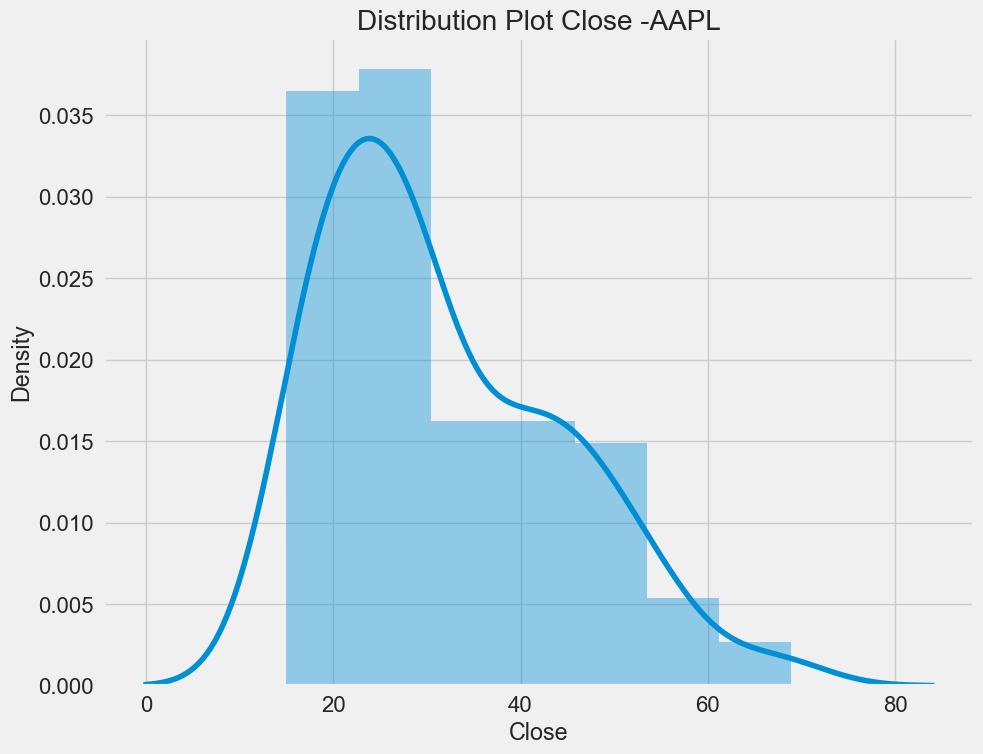

In [26]:
##Checking Distribution of Our Data 
import seaborn as sns
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly_data['Close']).set_title("Distribution Plot Close -AAPL")
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Distribution shows Right Skew

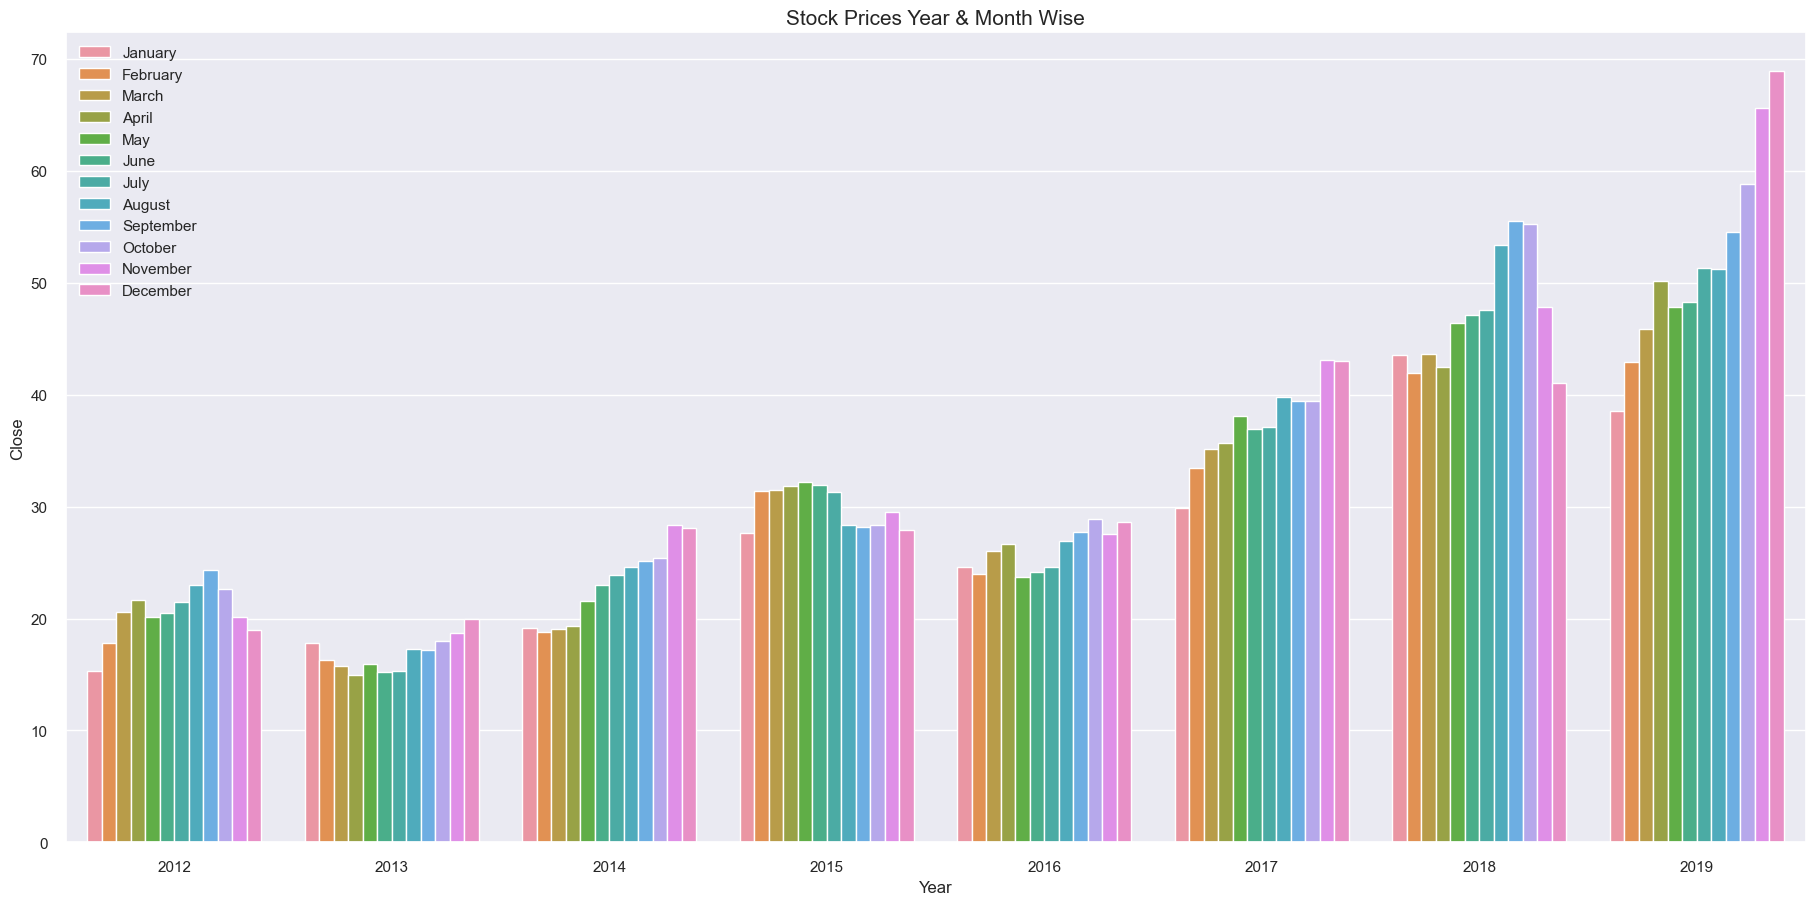

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="Close",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

Above figure shows that the Period from July-September seems to push stock price above in comparision to other months. The primary reason for this is as Apple has a product cycle release date during this time.

## Decomposition of Time Series

<Figure size 2000x1600 with 0 Axes>

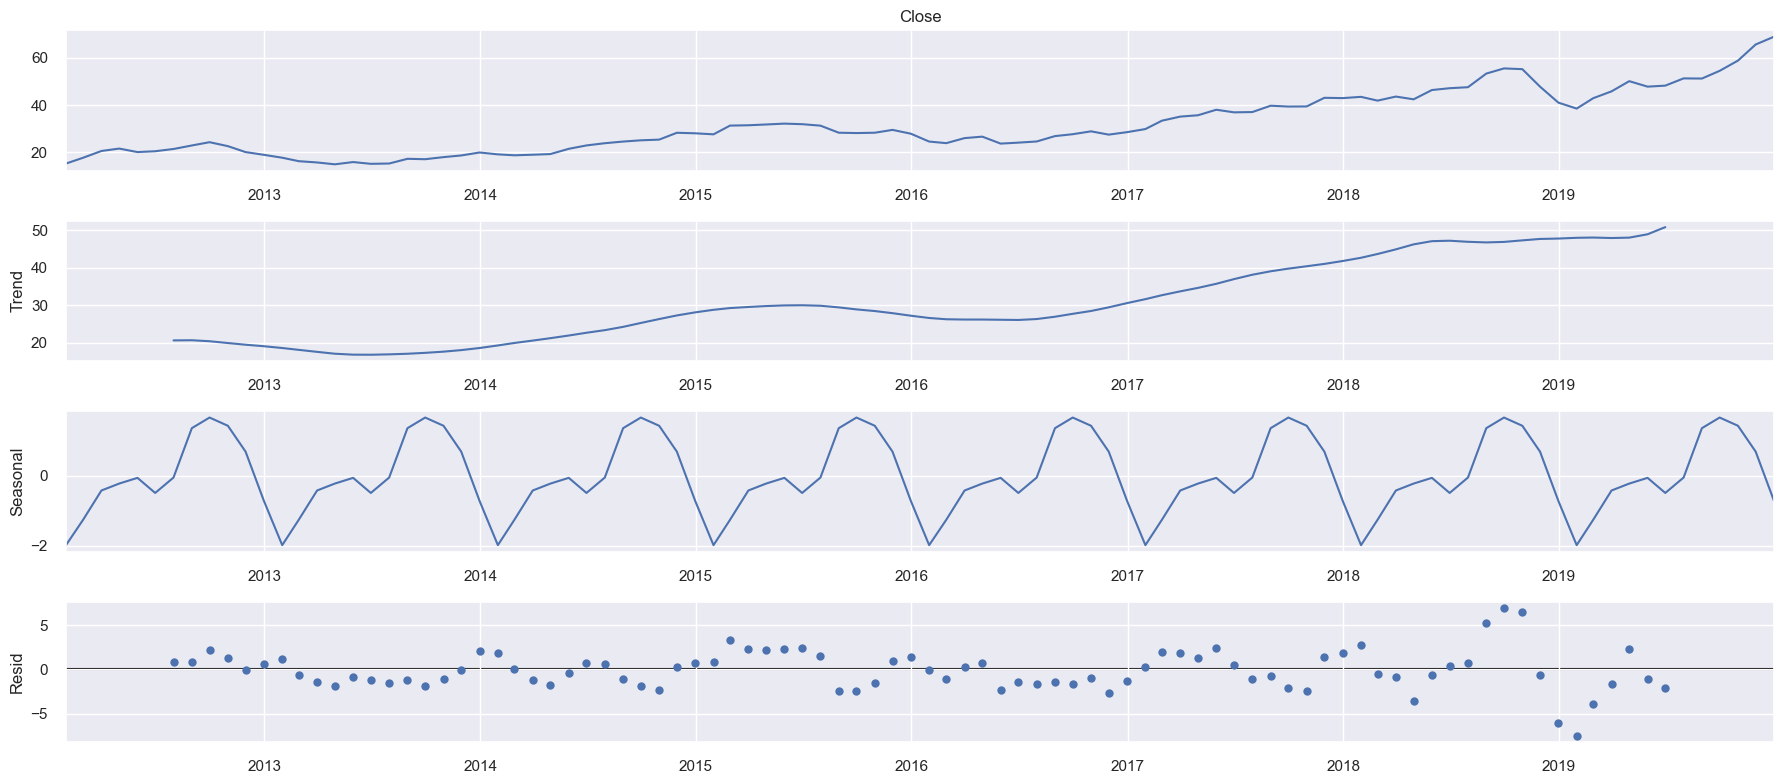

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly_data['Close'],model='additive', period=12)
decomposed_series.plot()
plt.show()

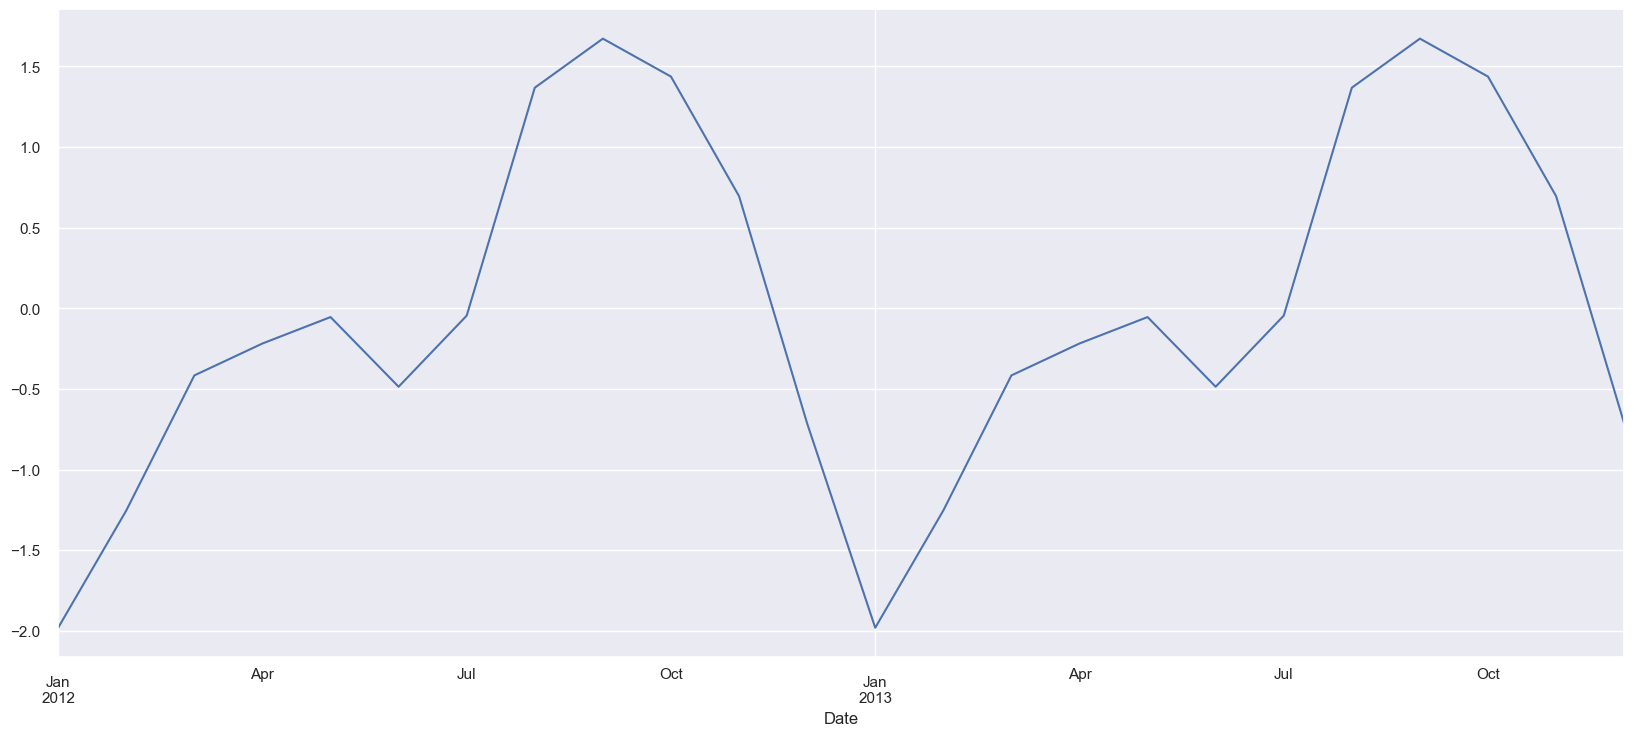

<Figure size 800x800 with 0 Axes>

In [30]:
#Observing Seasonality
decomposed_series.seasonal['2012':'2013'].plot()
fig = plt.figure(figsize=(8,8))

Trend : Overall an Upward Trend

Seasonality: There appears to be a 12-month seasonal pattern is visible, AAPL has rallied during the Holiday season as expected. Since Holiday period has good sales for Apple Over the Years.

## Stationary Test

Using Augmented Dickey-Fuller(ADF) Test

Null Hypothesis: Time series has a unit root -It is non-stationary

Alternate Hypothesis: Time series does not have a unit root -It is stationary

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.

In [31]:
#ADF Test

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
	  print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis-Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis-Time Series is Non-Stationary')

In [32]:
ad_fuller_func(monthly_data['Close'])

ADF Statistic: 0.512110
p-value: 0.985237
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Failed to Reject Null Hypothesis-Time Series is Non-Stationary


## Transformations To Make Series Stationary

In [33]:
##Differencing By 1
monthly_diff = monthly_data['Close'] - monthly_data['Close'].shift(1)

In [34]:
monthly_diff

Date
2012-01-31         NaN
2012-02-29    2.464036
2012-03-31    2.854883
2012-04-30    1.017688
2012-05-31   -1.476065
                ...   
2019-08-31   -0.064659
2019-09-30    3.259318
2019-10-31    4.322880
2019-11-30    6.808496
2019-12-31    3.287248
Freq: M, Name: Close, Length: 96, dtype: float64

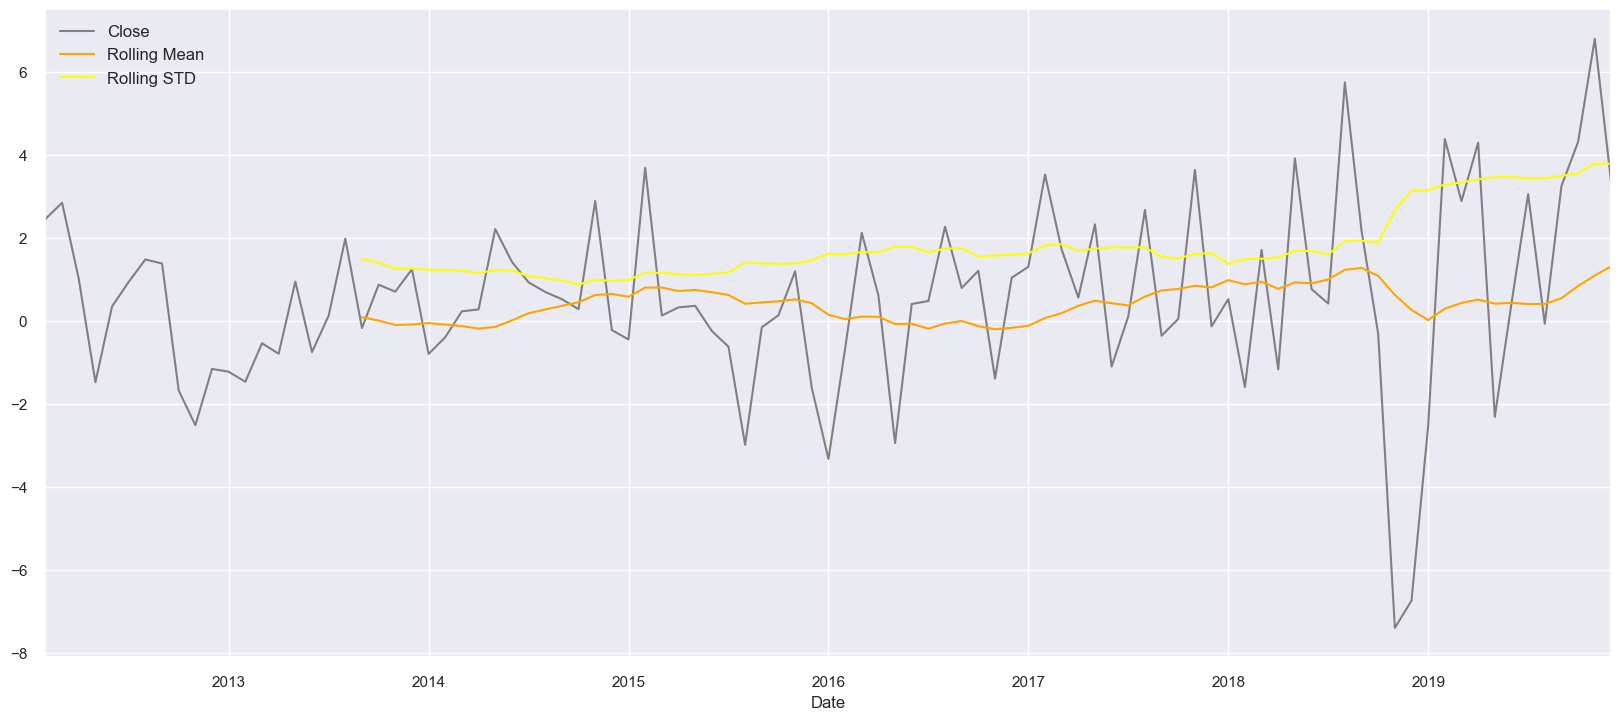

In [35]:
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [36]:
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -6.555009
p-value: 0.000000
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583
Reject Null Hypothesis-Time Series is Stationary


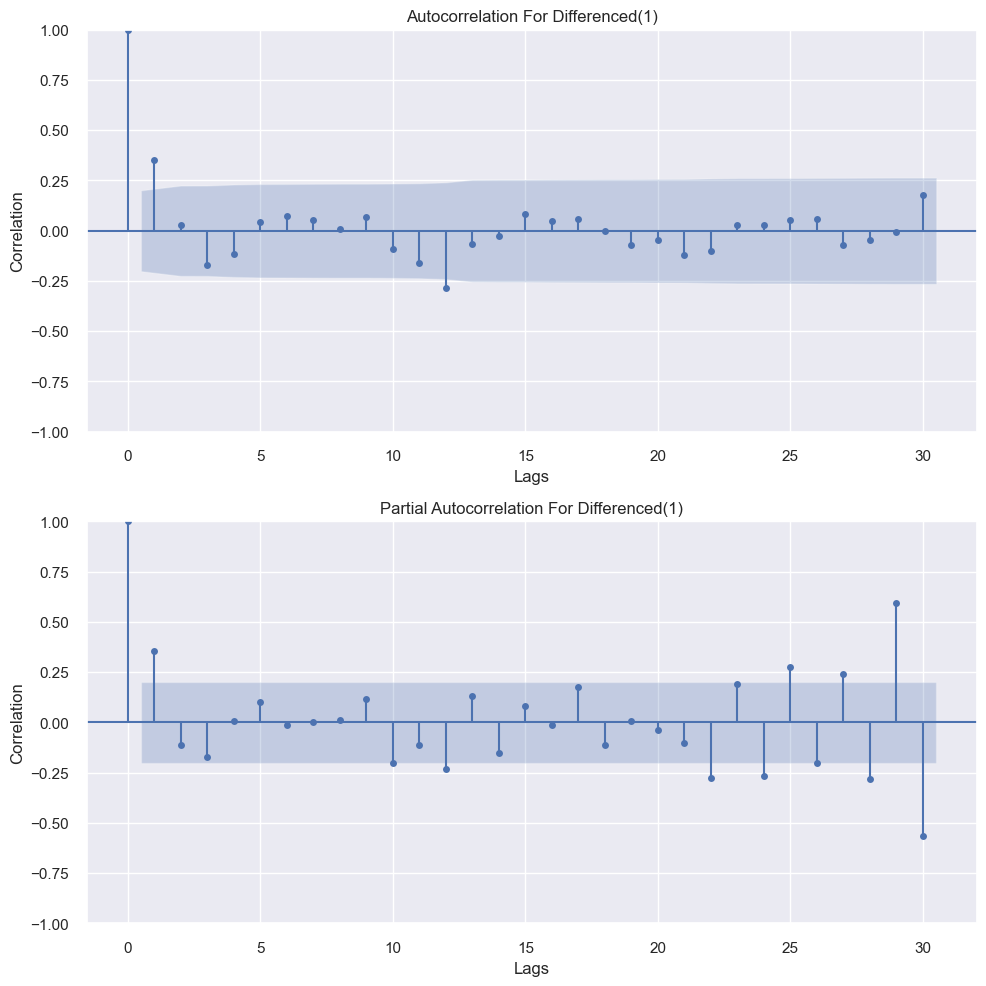

In [37]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,10))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

According to the ACF and PACF we can confirm that Differencing once has transformed series into Stationary
Here, p=1, q=1

### Modelling Seasonal ARIMA

In [38]:
modelling_series = monthly_data['Close']
modelling_series

Date
2012-01-31    15.306357
2012-02-29    17.770393
2012-03-31    20.625276
2012-04-30    21.642964
2012-05-31    20.166899
                ...    
2019-08-31    51.239432
2019-09-30    54.498750
2019-10-31    58.821630
2019-11-30    65.630126
2019-12-31    68.917374
Freq: M, Name: Close, Length: 96, dtype: float64

### Train-Test Split

In [39]:
from sklearn.model_selection import train_test_split as split
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [40]:
train.head(2)

Date
2012-01-31    15.306357
2012-02-29    17.770393
Freq: M, Name: Close, dtype: float64

In [41]:
test.head(2)

Date
2016-10-31    28.926786
2016-11-30    27.538571
Freq: M, Name: Close, dtype: float64

In [42]:
print('Train',len(train))
print('Test',len(test))

Train 57
Test 39


In [43]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [44]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .
Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=222.617, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=220.201, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=208.468, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=220.633, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=206.543, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=218.222, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.478 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. O

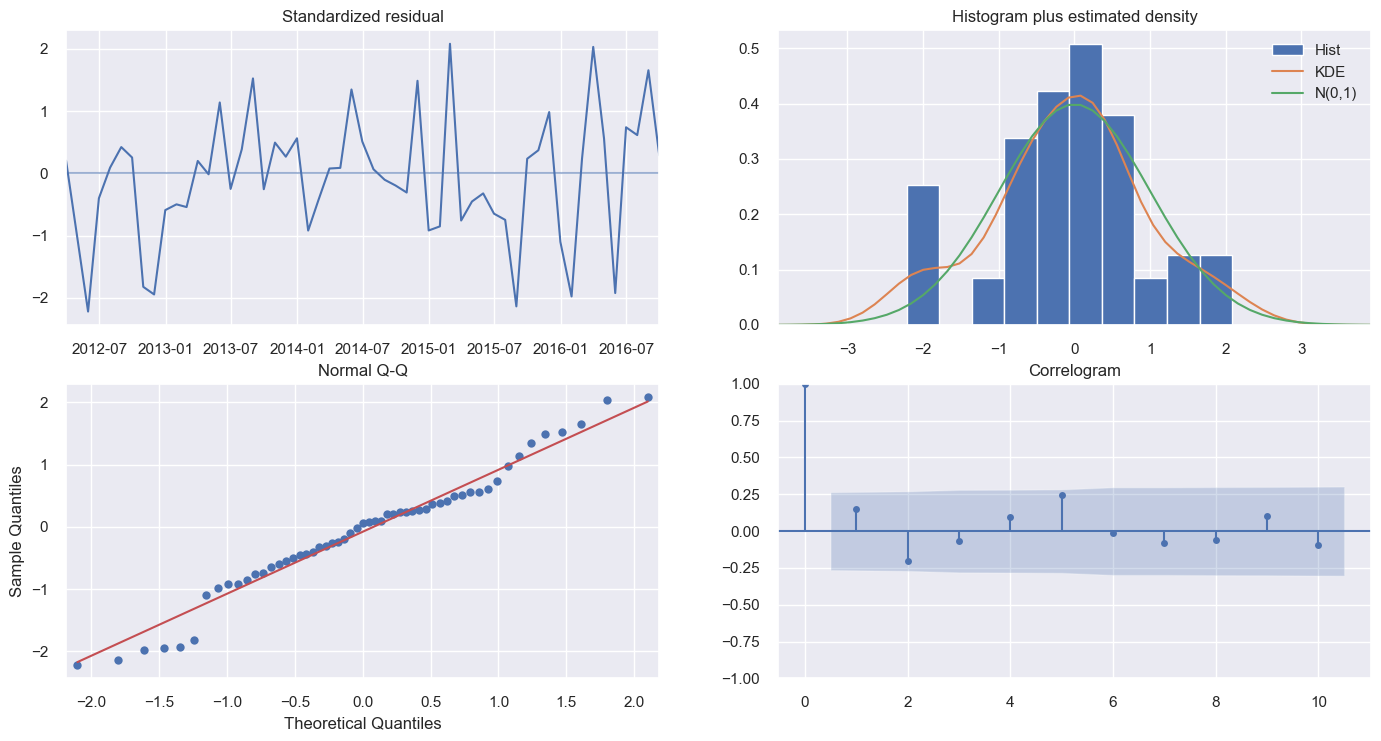

In [46]:
"""
#Using Auto-Arima for p, d, q(Different Method)
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
"""

### Hyper Parameter Tuning for Model Order

In [47]:

list_param = []
list_param_seasonal=[]
list_results_aic=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue
    break


"\nlist_param = []\nlist_param_seasonal=[]\nlist_results_aic=[]\n\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            model = sm.tsa.statespace.SARIMAX(train,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            results = model.fit()\n\n            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))\n            \n            list_param.append(param)\n            list_param_seasonal.append(param_seasonal)\n            list_results_aic.append(results.aic)\n        except:\n            continue\n    break\n"

By Observing the Lowest AIC , we come to Seasonality Order of (2,2,0)12 and non-seasonal component is (1,1,1) as derived earlier by correlograms.

In [48]:
model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
results=model.fit()
forecasts_train = results.predict(start='2012-01-31',end='2016-09-30')
forecasts_test = results.predict(start='2016-10-31',end='2019-12-31')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54179D+00    |proj g|=  8.84857D-02

At iterate    5    f=  1.40246D+00    |proj g|=  1.54636D-02

At iterate   10    f=  1.39967D+00    |proj g|=  1.70766D-02

At iterate   15    f=  1.39293D+00    |proj g|=  1.03834D-02

At iterate   20    f=  1.39275D+00    |proj g|=  2.25290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.738D-06   1.393D+00
  F =   1.3927533090963329     

CONVERG

In [49]:
##Function to Calculate Result Metrics
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))
  print('Mean Absolute Percentage Error ',round(mean_absolute_percentage_error(test_series,forecast_series),3))
  print('Root Mean Squared Error : ',sqrt(mean_squared_error(test_series,forecast_series)))
    

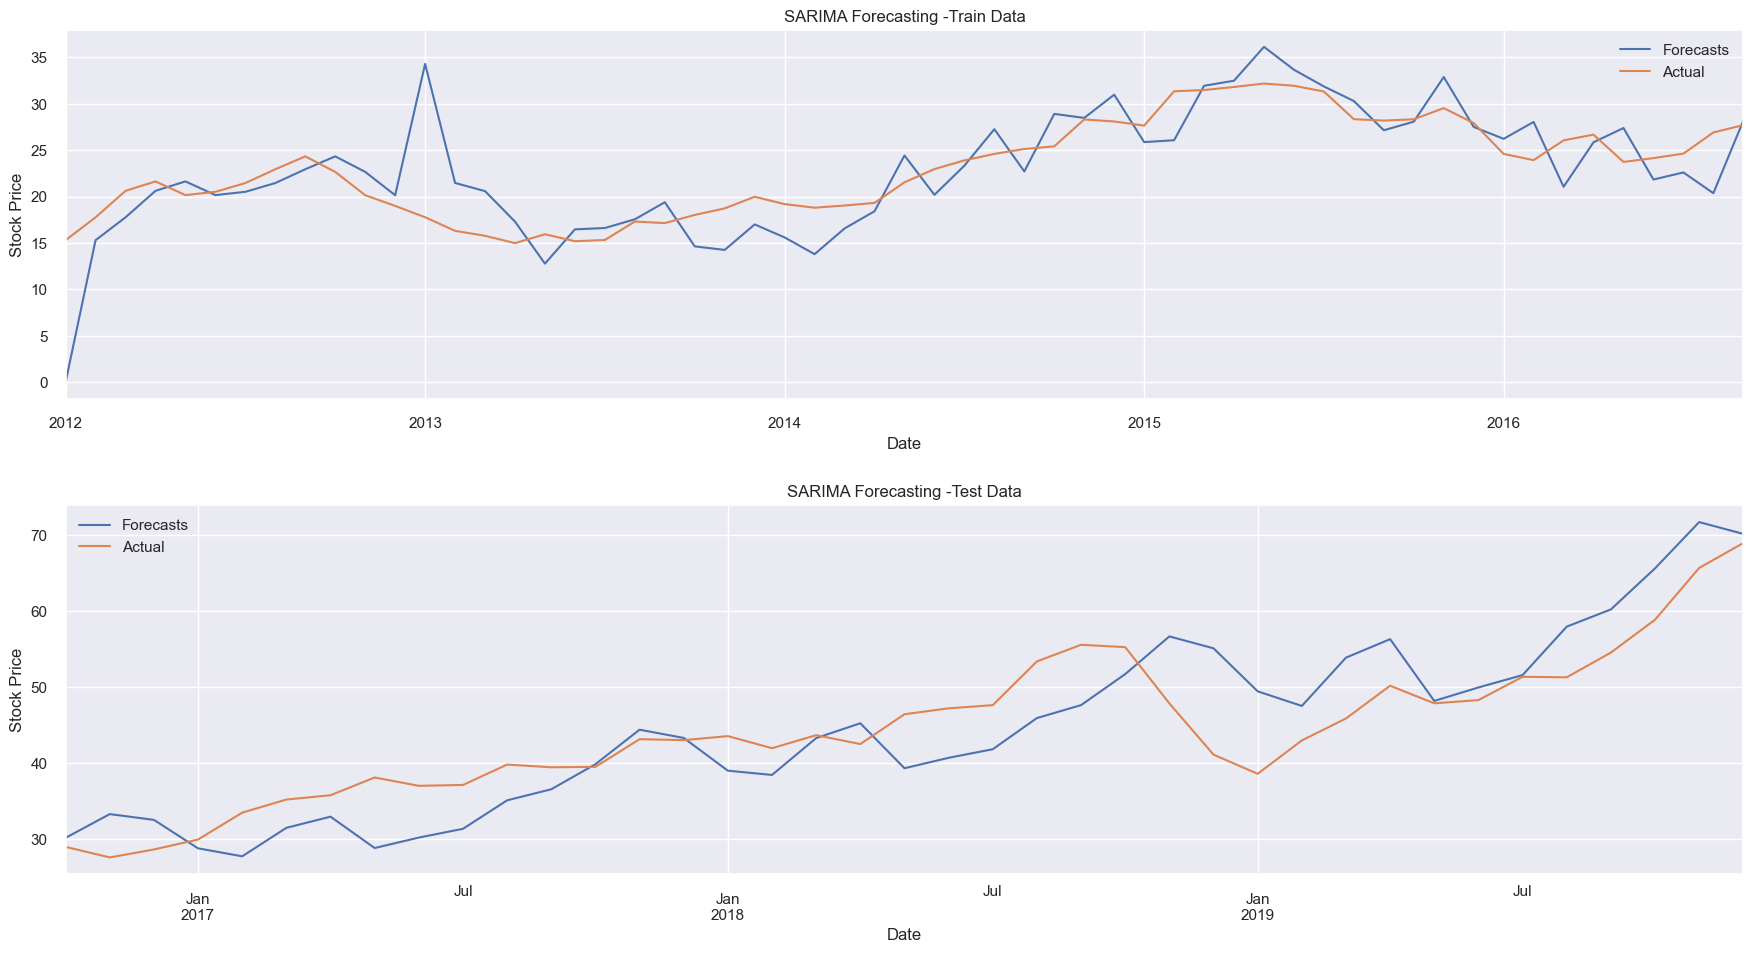

In [50]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
train.plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
test.plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [51]:
print(result_metrics(train,forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(test,forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.356
Mean Squared Error :  16.274
Mean Absolute Error :  2.779
Mean Absolute Percentage Error  0.136
Root Mean Squared Error :  4.034120937886546
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.626
Mean Squared Error :  32.782
Mean Absolute Error :  4.769
Mean Absolute Percentage Error  0.111
Root Mean Squared Error :  5.725586852381987
None


In [52]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                   57
Model:             SARIMAX(1, 1, 1)x(2, 2, [], 12)   Log Likelihood                 -79.387
Date:                             Thu, 15 Dec 2022   AIC                            168.774
Time:                                     14:36:04   BIC                            176.103
Sample:                                 01-31-2012   HQIC                           171.203
                                      - 09-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7741      0.436      1.775      0.076      -0.080       1.629
ma.L1         -0.5035      

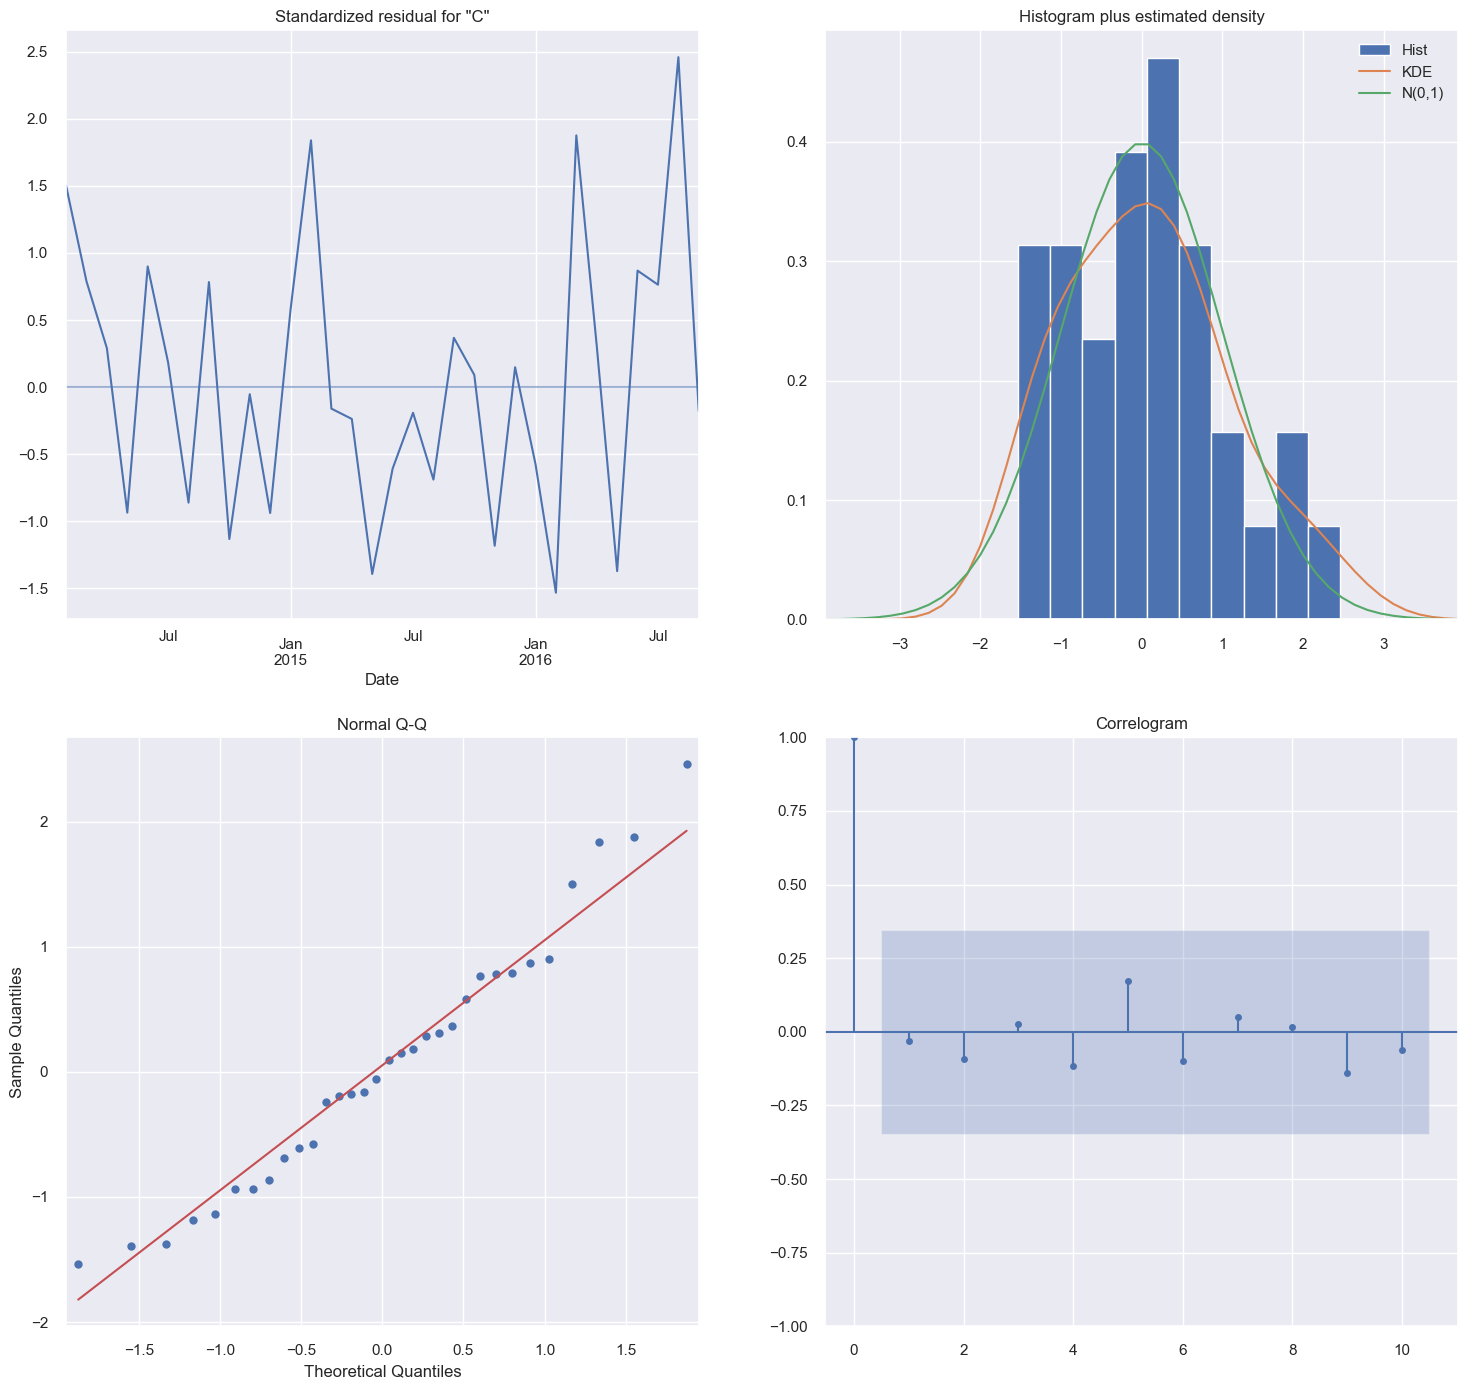

In [53]:
##Checking Model Diagnotics on Training Data
results.plot_diagnostics(figsize=(16, 16))
plt.show()

### Residual Analysis

In [54]:
residuals_test = test-forecasts_test

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


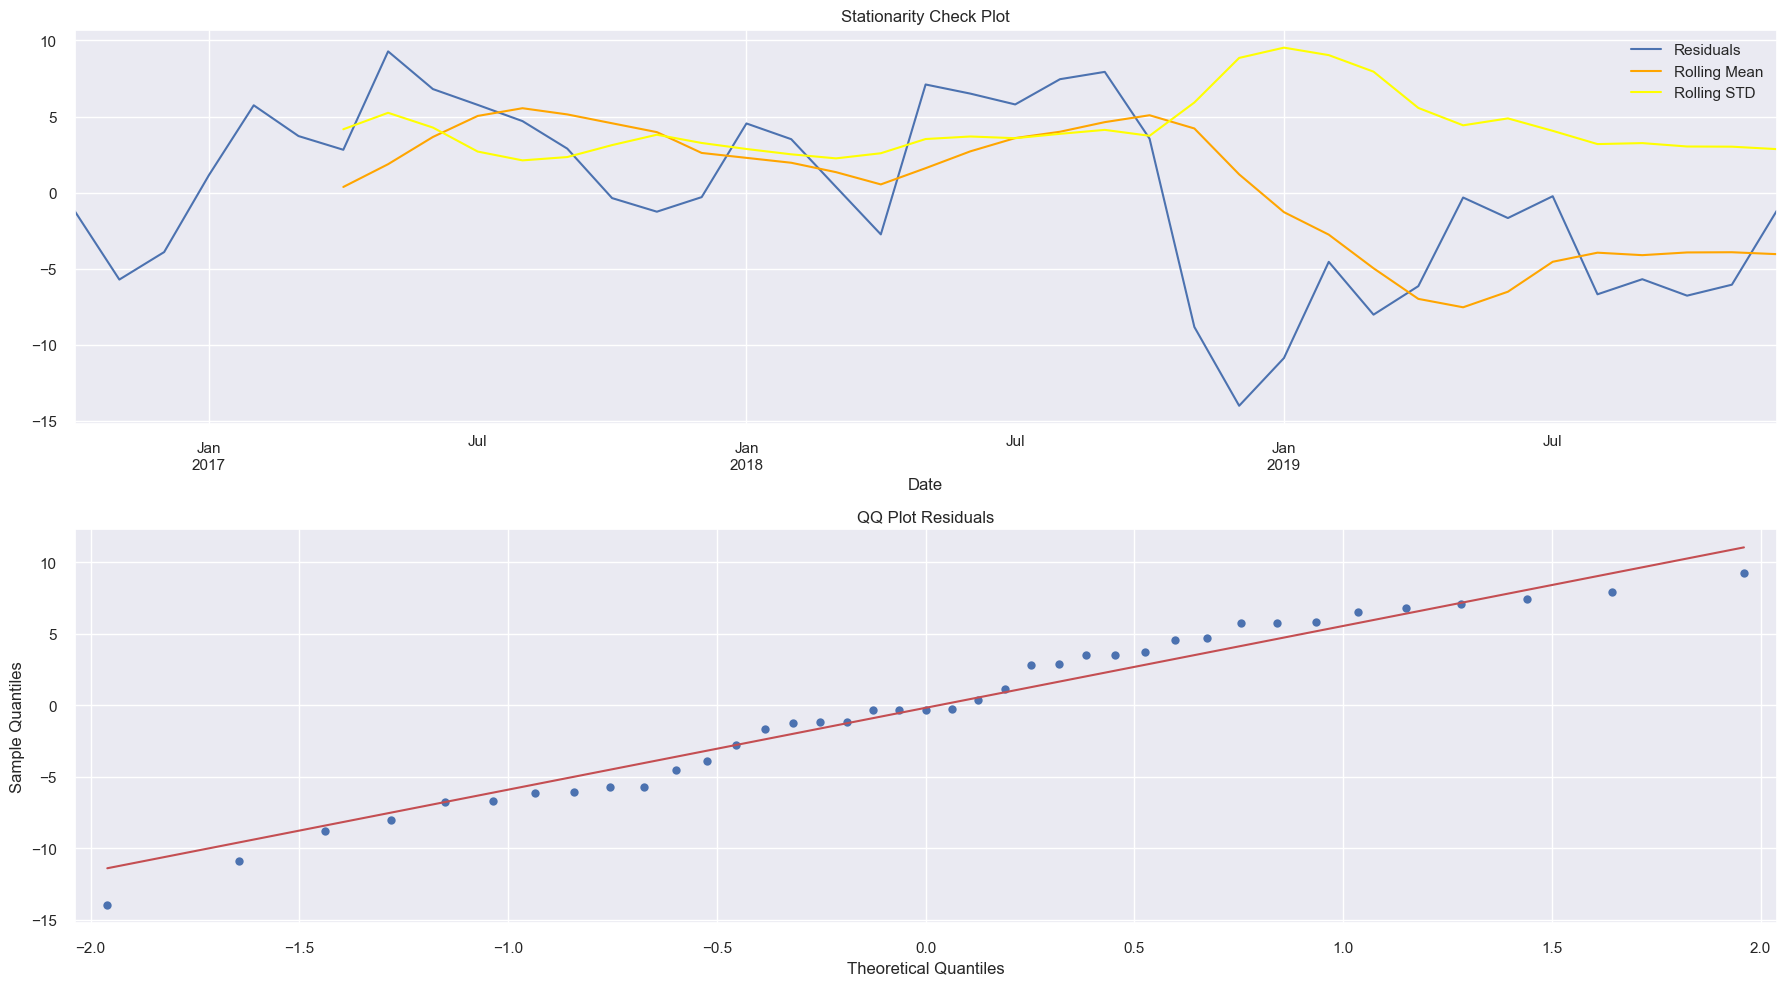

In [55]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))


residuals_test.plot(label='Residuals',ax=ax1,title='Stationarity Check Plot')
residuals_test.rolling(7).mean().plot(label='Rolling Mean',c='orange',ax=ax1)
residuals_test.rolling(7).std().plot(label='Rolling STD',c='yellow',ax=ax1)

qq_plot = qq(residuals_test,line='s',ax=ax2)
ax2.set_title('QQ Plot Residuals')
ax1.legend()
ax2.legend()
plt.tight_layout(pad=1)

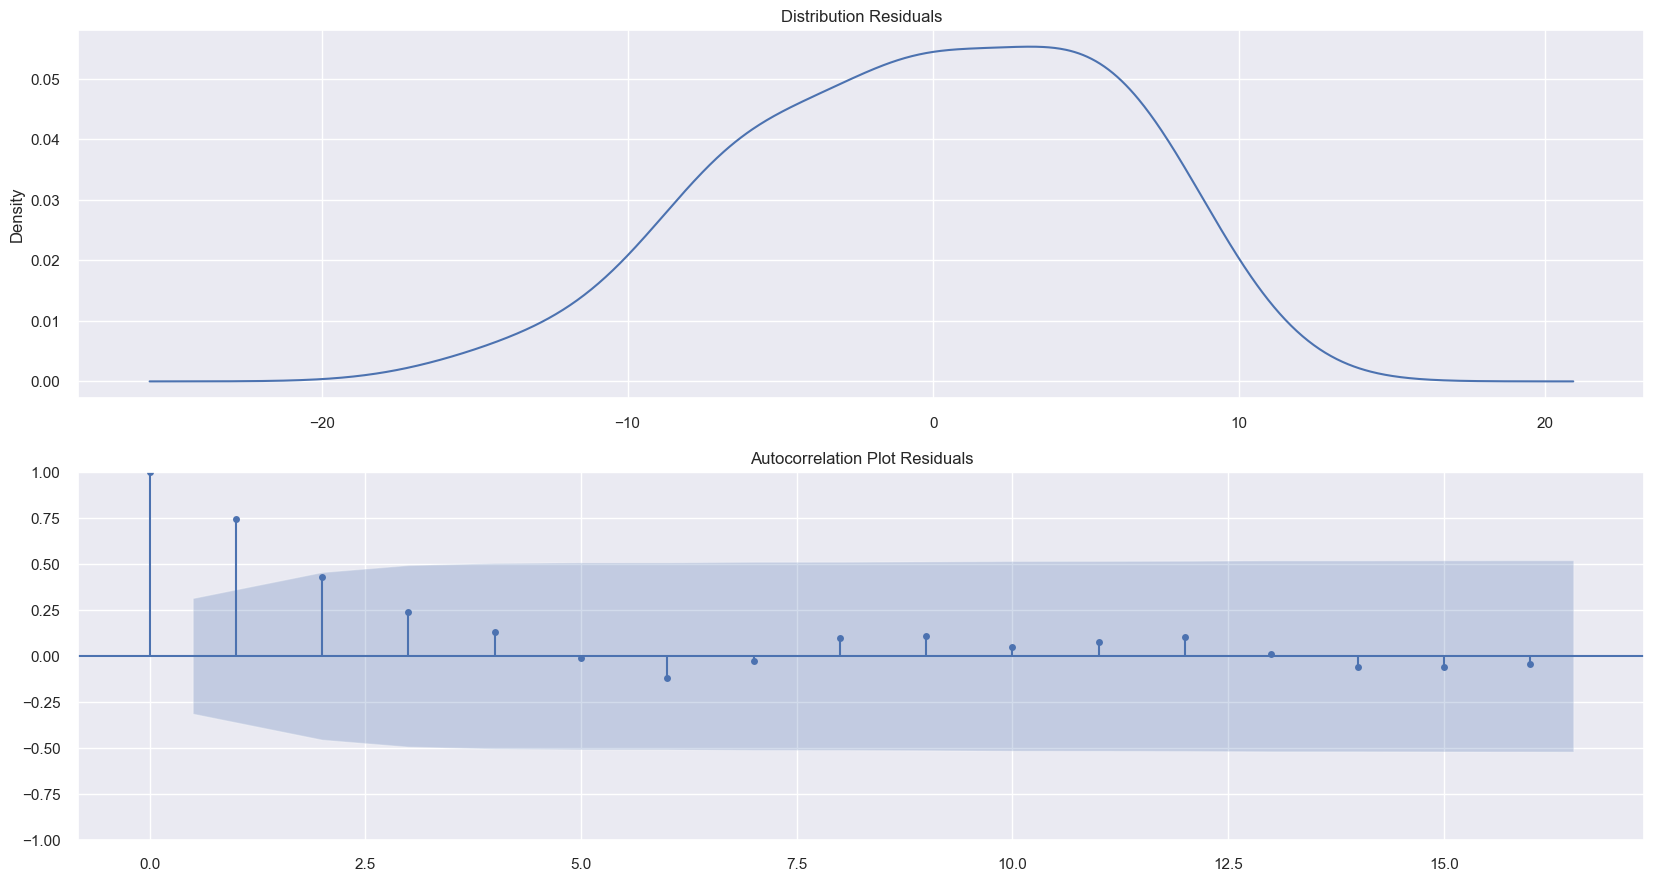

In [56]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

residuals_test.plot(kind='kde',ax=ax1,title='Distribution Residuals')

acf = plot_acf(residuals_test,ax=ax2,title='Autocorrelation Plot Residuals')

In [57]:
residuals_test.describe()

count    39.000000
mean     -0.168518
std       5.797921
min     -13.988359
25%      -5.108477
50%      -0.288128
75%       4.627034
max       9.283400
dtype: float64

In [58]:
train_list = {}
test_list = {}
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values

index = 1
for train_index, test_index in time_series_splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_list[index] = train
    test_list[index] = test
    index += 1

In [59]:
modelling_series

Date
2012-01-31    15.306357
2012-02-29    17.770393
2012-03-31    20.625276
2012-04-30    21.642964
2012-05-31    20.166899
                ...    
2019-08-31    51.239432
2019-09-30    54.498750
2019-10-31    58.821630
2019-11-30    65.630126
2019-12-31    68.917374
Freq: M, Name: Close, Length: 96, dtype: float64

In [60]:
def backtest_model(train,test):
    model = sm.tsa.SARIMAX(train,order=(1,1,1),seasonal_order=(2,2,0,12))
    results=model.fit()


    # train_get_dates_beginning = '2012-01-31'
    # train_get_dates_ending = str(modelling_series.index[len(train)].date())
    # test_get_dates_beginning = train_get_dates_ending
    # test_get_dates_ending = str(modelling_series.index[len(train)+len(test)].date())


    # forecasts_train = results.predict(start=train_get_dates_beginning,end=train_get_dates_ending)
    # forecasts_test = results.predict(start=test_get_dates_beginning,end=test_get_dates_ending)

    forecasts_train = results.predict(start=0,end=len(train))
    forecasts_test = results.predict(start=len(train),end=len(train)+len(test))


    fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    forecasts_train = pd.DataFrame(forecasts_train)
    forecasts_test = pd.DataFrame(forecasts_test)

    forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
    train.plot(label='Actual',ax=ax1)
    ax1.set_ylabel('Stock Price')

    forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
    test.plot(label='Actual',ax=ax2)
    ax2.set_ylabel('Stock Price')

    ax1.legend()
    ax2.legend()
    plt.tight_layout(pad=2)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79812D+00    |proj g|=  1.02692D-01


 This problem is unconstrained.



At iterate    5    f=  1.71049D+00    |proj g|=  1.44022D-02

At iterate   10    f=  1.70850D+00    |proj g|=  9.84909D-03

At iterate   15    f=  1.70810D+00    |proj g|=  2.04565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.046D-06   1.708D+00
  F =   1.7081049367795511     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


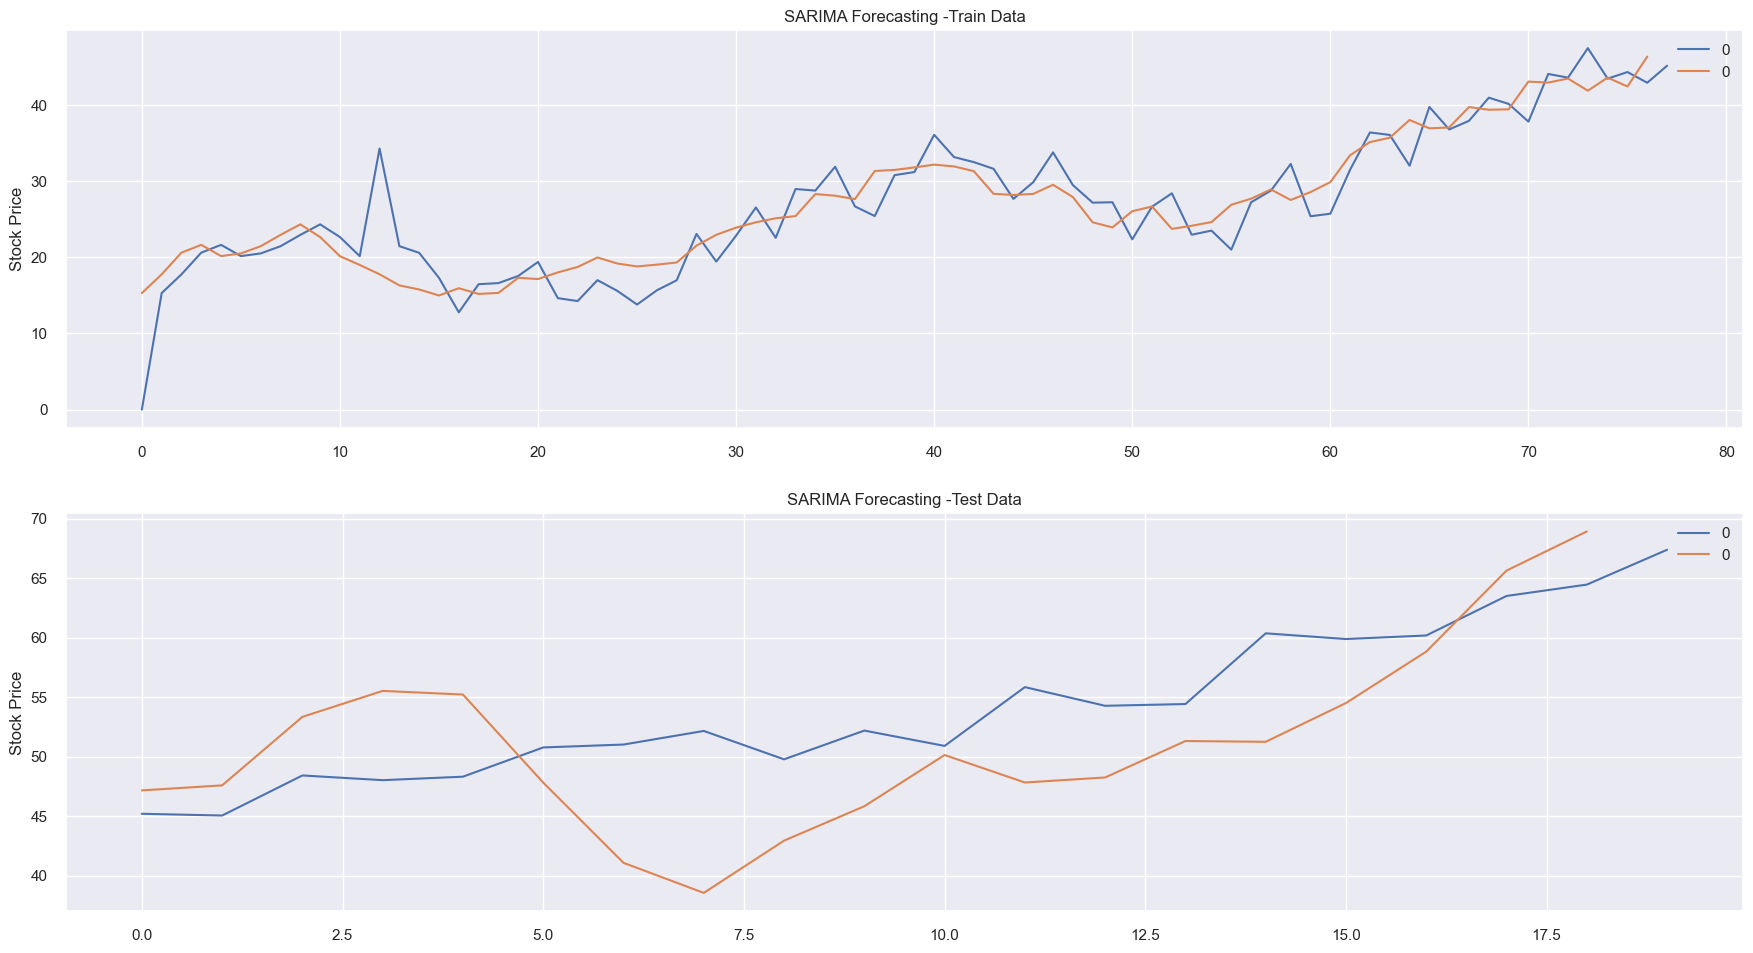

In [61]:
backtest_model(train,test)

In [62]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(monthly_data['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29170D+00    |proj g|=  1.19562D-01

At iterate    5    f=  2.18683D+00    |proj g|=  2.64241D-02

At iterate   10    f=  1.95971D+00    |proj g|=  3.75030D-02

At iterate   15    f=  1.95826D+00    |proj g|=  2.88149D-03


 This problem is unconstrained.



At iterate   20    f=  1.95749D+00    |proj g|=  5.56766D-02

At iterate   25    f=  1.94181D+00    |proj g|=  1.23549D-02

At iterate   30    f=  1.94162D+00    |proj g|=  4.60735D-04

At iterate   35    f=  1.94159D+00    |proj g|=  2.72018D-03

At iterate   40    f=  1.94155D+00    |proj g|=  1.50921D-03

At iterate   45    f=  1.94154D+00    |proj g|=  4.87615D-05

At iterate   50    f=  1.94154D+00    |proj g|=  9.58559D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   9.586D-05   1.942D+00
  F =   1.9415416327507635     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

<AxesSubplot:xlabel='Date'>

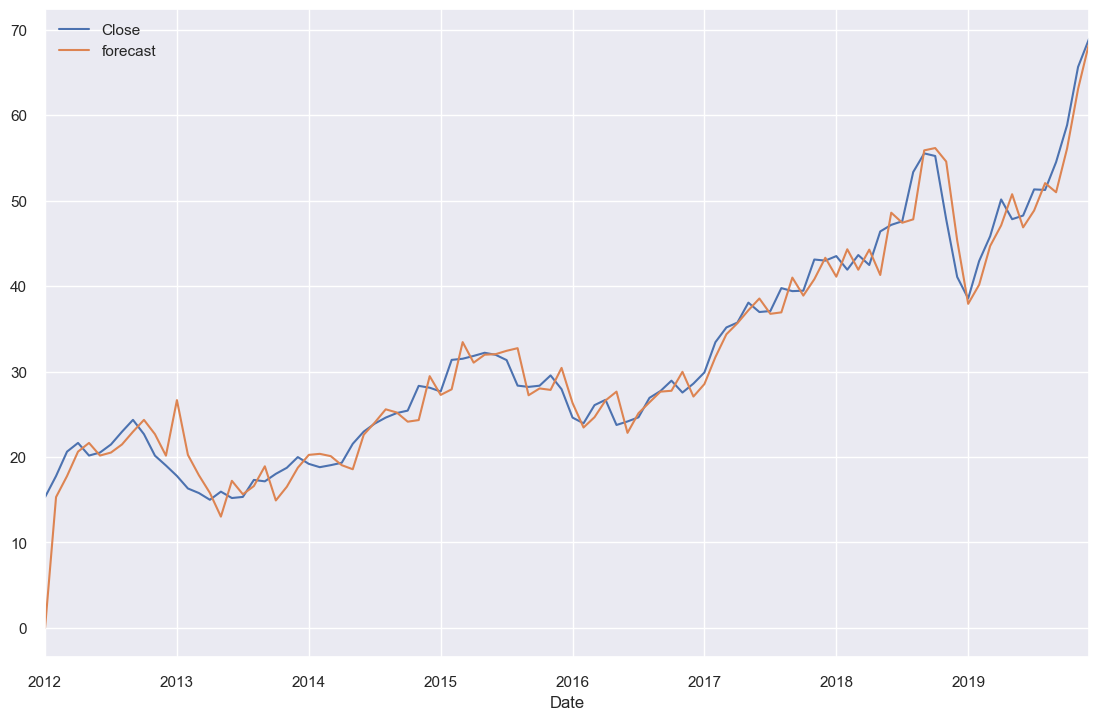

In [63]:
monthly_data['forecast']=results.predict()
monthly_data[['Close' ,'forecast']].plot(figsize=(12,8))

In [64]:
monthly_data.tail(16)

,Close,Year,Month,dayofweek,quarter,forecast
Date,,,,,,
2018-09-30,55.518421,2018,September,Sunday,3,55.869537
2018-10-31,55.211413,2018,October,Wednesday,4,56.141917
2018-11-30,47.808929,2018,November,Friday,4,54.562350
2018-12-31,41.066579,2018,December,Monday,4,45.344618
2019-01-31,38.541548,2019,January,Thursday,1,37.914681
2019-02-28,42.931973,2019,February,Thursday,1,40.154566
2019-03-31,45.823453,2019,March,Sunday,1,44.678915
2019-04-30,50.129048,2019,April,Tuesday,2,47.091288
2019-05-31,47.818409,2019,May,Friday,2,50.741202


In [69]:
from pandas.tseries.offsets import DateOffset
future_dates=[monthly_data.index[-1]+ DateOffset(months=x)for x in range(0,12)]

In [70]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=monthly_data.columns)

In [71]:
future_df=pd.concat([monthly_data,future_datest_df])

<AxesSubplot:>

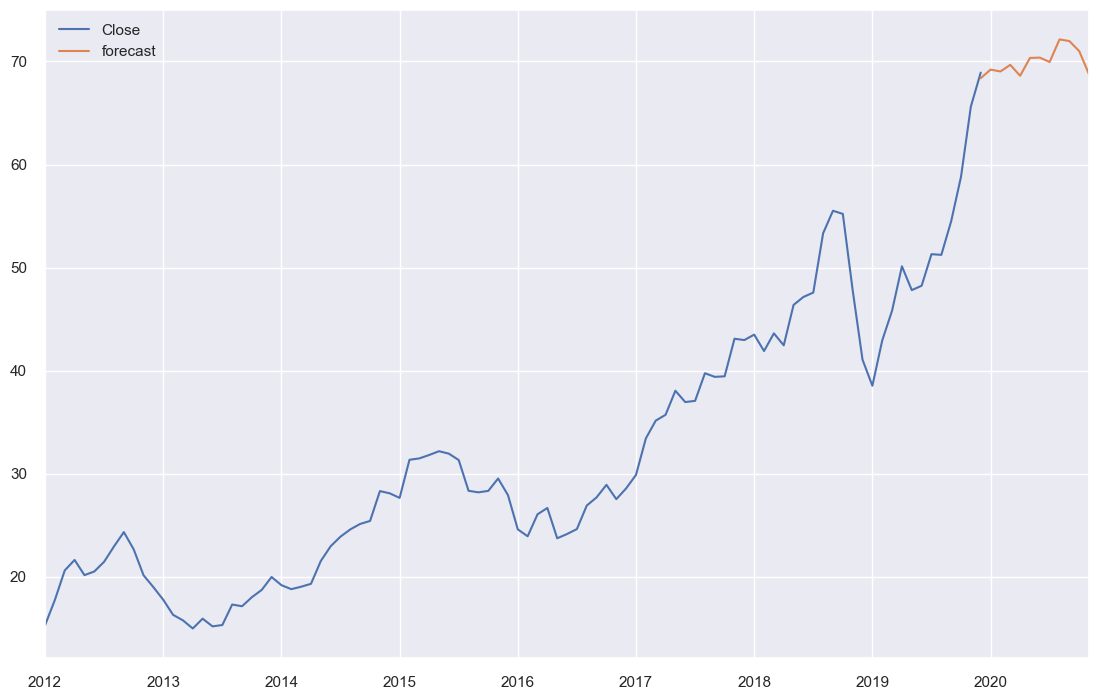

In [72]:
future_df['forecast'] = results.predict(start =95, end = 170)
future_df[['Close', 'forecast']].plot(figsize=(12, 8))